## 1. Hipótese escolhida: 3

### *Bolsas e desempenho acadêmico*

Estudantes com bolsa/financiamento (Prouni, FIES, Bolsa Institucional) tendem a manter CRA semelhante ou superior a não bolsistas, após considerar Renda_Familiar_SM, Nota_ENEM e Horas_Estudo_Semanais.

_Tarefa:_ Regressão KNN para CRA; análise de importância empírica via desempenho por subconjuntos; discutir se o padrão se mantém entre Tipo_IES (Pública vs. Privada).

## 2. Carga e checagem dos dados: 

leitura do CSV, info(), describe(), verificação de nulos.

In [53]:
# importa bibliotecas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer




df = pd.read_csv('dataset_educacao_graduacao_brasil_500.csv')

In [54]:
# Verificação de informações gerais
print(df.head(10))
print(df.info(), "\n")
print(df.isnull().sum(), "\n") 

         Regiao Localidade Cidade_Tamanho Tipo_IES  Modalidade     Periodo  \
0           Sul   Interior          Média  Privada  Presencial     Noturno   
1  Centro-Oeste   Interior        Pequena  Privada         EAD  Vespertino   
2       Sudeste   Interior         Grande  Privada     Híbrido    Integral   
3       Sudeste   Interior      Metrópole  Privada  Presencial  Vespertino   
4           Sul    Capital          Média  Privada         EAD    Matutino   
5         Norte   Interior          Média  Privada  Presencial    Matutino   
6      Nordeste   Interior        Pequena  Privada  Presencial    Matutino   
7           Sul   Interior         Grande  Privada  Presencial     Noturno   
8       Sudeste   Interior        Pequena  Privada  Presencial    Matutino   
9      Nordeste   Interior         Grande  Privada         EAD    Integral   

                Area     Genero Cor_Raca  Idade  ...  Nota_ENEM  \
0      Licenciaturas   Feminino    Parda     20  ...        714   
1      

## 3. Pré-processamento: 
seleção de features, codificação de categóricas (se necessário), padronização (via Pipeline).

In [55]:
# Seleção de features e target
target = "CRA" # o que queremos prever
numeric_features = ["Renda_Familiar_SM", "Nota_ENEM", "Horas_Estudo_Semanais"] 
categorical_features = ["Bolsa_ou_Financiamento", "Tipo_IES"]

features = numeric_features + categorical_features

X = df[features].copy() 
y = df[target].copy() 

# Separar features e target
X = df[features].copy()
y = df[target].copy()


In [56]:
# separação de dados em conjunto de treinamento e conjunto de testes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Formato treino:", X_train.shape) # mostra numero de linhas e colunas do conjunto de treino
print("Formato teste:", X_test.shape) # mostra numero de linhas e colunas do conjunto de teste

Formato treino: (400, 5)
Formato teste: (100, 5)



### Padronização: 
- Preenchimento de valores nulos nas colunas numéricas com a mediana, com o objetivo de não diminuir drasticamente a quantidade de dados no dataset.

- Padronização de todas as colunas numéricas para a mesma escala (média 0, desvio 1), para que o modelo KNN não atribua maior peso automaticamente a variáveis maiores.

- Encapsula essas transformações em um Pipeline, que pode ser combinado com as transformações das colunas categóricas na próxima etapa.

In [57]:

# Numéricas: preencher nulos e padronizar
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # preencher nulos com mediana (para não alterar significativamente o tamanho do dataset)
    ("scaler", StandardScaler()) # padronizar para média=0, desvio=1
])

## 4. Split treino/teste: 
70/30 (use random_state para reprodutibilidade; para classificação, use stratify se fizer sentido)


In [58]:
# Dividindo os dados em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, # 30% para teste
    random_state=42, # garante que a divisão seja sempre igual
    stratify=None # apenas para classificação. aqui é regressão, então None
)



## 5. Modelagem KNN:
• Regressão (CRA) ou Classificação (Risco_Evasao), conforme hipótese.

• Comparar k (faixa p.ex. 1–31) e métrica de distância (euclidiana/manhattan).

• Mostrar curvas de desempenho (treino vs. teste) para discutir overfitting/underfitting.

- **Objetivo:** Prever o CRA dos estudantes usando KNN.

**Pré-processamento:**

***Numéricas*** → preencher nulos com mediana e padronizar (média=0, desvio=1).

***Categóricas*** → preencher nulos com a categoria mais frequente e aplicar OneHotEncoding.

***Treino e teste***: Divididos em treino/teste (70/30) e transformados pelo preprocessor.

*Hiperparâmetros testados:*

k = 1 a 31 (apenas ímpares).

**Métricas de distância:** euclidiana e manhattan.

*Avaliação:*

R² no treino e no teste para cada combinação de k e métrica.

Curvas de desempenho permitem identificar overfitting ou underfitting.

__Resultado final:__ Escolha do melhor k e melhor métrica com base no R² do conjunto de teste.

In [112]:

# Numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categóricas
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer: aplica transformações específicas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)



In [113]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# Converter para array denso se vier esparso
try:
    import scipy.sparse as sp
    if sp.issparse(X_train_processed):
        X_train_processed = X_train_processed.toarray()
        X_test_processed  = X_test_processed.toarray()
except Exception as e:
    print("Aviso: não foi possível checar/convertar esparsidade:", e)

print("Treino processado:", X_train_processed.shape)
print("Teste processado :", X_test_processed.shape)


Treino processado: (350, 9)
Teste processado : (150, 9)


In [114]:
k_values = list(range(1, 32, 2))  # k ímpares de 1 a 31
distance_metrics = ["euclidean", "manhattan"]

print("k testados:", k_values)
print("Métricas testadas:", distance_metrics)


k testados: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
Métricas testadas: ['euclidean', 'manhattan']


In [115]:


results = {}

for metric in distance_metrics:
    train_scores = []
    test_scores = []

    for k in k_values:
        model = KNeighborsRegressor(n_neighbors=k, metric=metric)
        model.fit(X_train_processed, y_train)

        y_train_pred = model.predict(X_train_processed)
        y_test_pred  = model.predict(X_test_processed)

        train_scores.append(r2_score(y_train, y_train_pred))
        test_scores.append(r2_score(y_test, y_test_pred))

    results[metric] = {"train": train_scores, "test": test_scores}



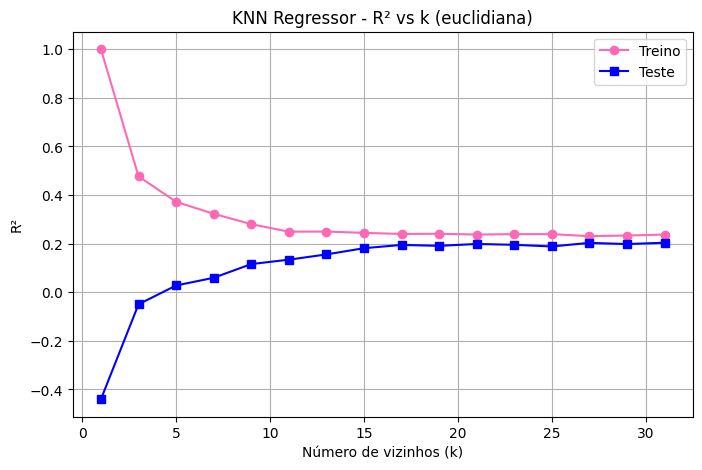

In [116]:
plt.figure(figsize=(8,5))
plt.plot(k_values, results["euclidean"]["train"], marker="o", label="Treino", color='hotpink')
plt.plot(k_values, results["euclidean"]["test"], marker="s", label="Teste", color='blue')
plt.title("KNN Regressor - R² vs k (euclidiana)")
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()


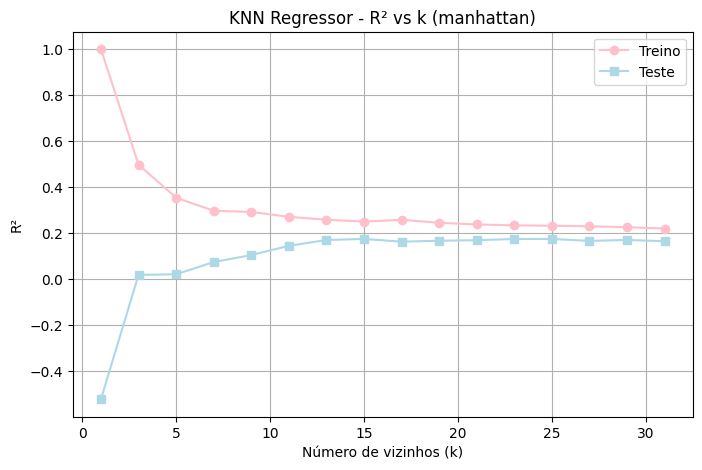

In [117]:
plt.figure(figsize=(8,5))
plt.plot(k_values, results["manhattan"]["train"], marker="o", label="Treino", color='pink')
plt.plot(k_values, results["manhattan"]["test"], marker="s", label="Teste", color='lightblue')
plt.title("KNN Regressor - R² vs k (manhattan)")
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()


In [118]:
best_by_metric = {}
best_overall = {"metric": None, "k": None, "r2_test": -1}

for metric in distance_metrics:
    test_scores = results[metric]["test"]
    idx_best = max(range(len(test_scores)), key=lambda i: test_scores[i])
    k_best = k_values[idx_best]
    r2_best = test_scores[idx_best]
    best_by_metric[metric] = (k_best, r2_best)

    if r2_best > best_overall["r2_test"]:
        best_overall = {"metric": metric, "k": k_best, "r2_test": r2_best}

print("Melhor por métrica:")
for metric, (k_best, r2_best) in best_by_metric.items():
    print(f"  - {metric}: k={k_best} | R² teste={r2_best:.4f}")

print("\nMelhor geral:")
print(f"  -> métrica={best_overall['metric']} | k={best_overall['k']} | R² teste={best_overall['r2_test']:.4f}")


Melhor por métrica:
  - euclidean: k=31 | R² teste=0.2037
  - manhattan: k=15 | R² teste=0.1752

Melhor geral:
  -> métrica=euclidean | k=31 | R² teste=0.2037


## 6. Avaliação:

•Regressão: MAE, MSE, R2 + gráfico y_real vs. y_previsto.

•Classificação: acurácia, matriz de confusão e (se aplicável) precisão/recall/F1.

In [96]:
# importa métricas:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# criar modelo com melhor k e métrica
best_model = KNeighborsRegressor(n_neighbors=best_overall["k"], metric=best_overall["metric"])
best_model.fit(X_train_processed, y_train)

# predições
y_train_pred = best_model.predict(X_train_processed)
y_test_pred  = best_model.predict(X_test_processed)

# cálculo das métricas
mae_train = mean_absolute_error(y_train, y_train_pred) # erro médio absoluto, indica quanto a previsão erra em média
mse_train = mean_squared_error(y_train, y_train_pred) # erro quadrático médio, penaliza erros maiores
r2_train  = r2_score(y_train, y_train_pred) # proporção da variabilidade explicada pelo modelo

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)

print("Treino: MAE={:.3f}, MSE={:.3f}, R²={:.3f}".format(mae_train, mse_train, r2_train))
print("Teste : MAE={:.3f}, MSE={:.3f}, R²={:.3f}".format(mae_test, mse_test, r2_test))




Treino: MAE=0.860, MSE=1.068, R²=0.237
Teste : MAE=0.869, MSE=1.180, R²=0.204


C:\Users\Inteli\AppData\Local\Temp\ipykernel_19800\91749407.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label="y = y_previsto", color='darkcyan')


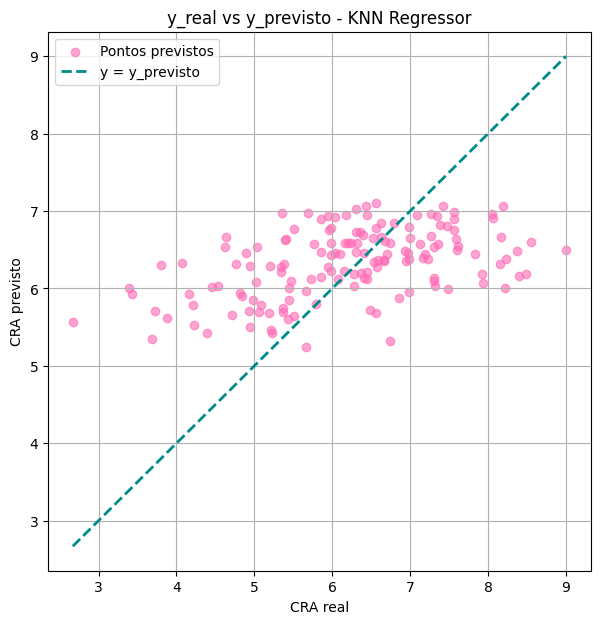

In [95]:
# gráfico
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred, color="hotpink", alpha=0.6, label="Pontos previstos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label="y = y_previsto", color='darkcyan')
plt.xlabel("CRA real")
plt.ylabel("CRA previsto")
plt.title("y_real vs y_previsto - KNN Regressor")
plt.legend()
plt.grid(True)
plt.show()


## 7. Análises por subgrupos relevantes à hipótese 
(ex.: Acesso_Internet, Modalidade, Tipo_IES).

Bolsa_ou_Financiamento
FIES                   6.013478
Nenhum                 6.182704
Prouni                 6.383187
Bolsa Institucional    6.419643
Name: CRA, dtype: float64


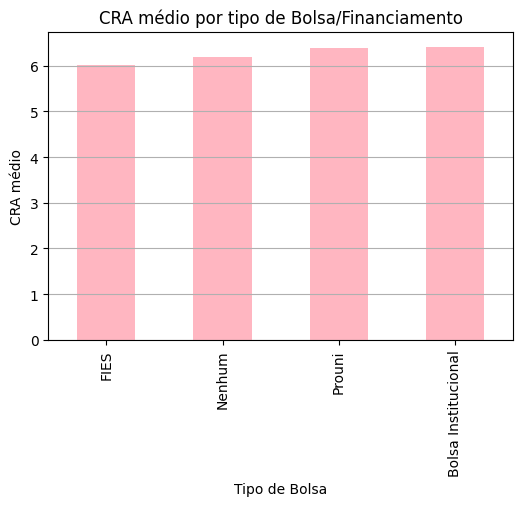

In [99]:
# CRA médio por Bolsa_ou_Financiamento
# Agrupar por Bolsa e calcular média do CRA
cra_por_bolsa = df.groupby("Bolsa_ou_Financiamento")["CRA"].mean().sort_values()
print(cra_por_bolsa)

# Gráfico
cra_por_bolsa.plot(kind="bar", color="lightpink", figsize=(6,4))
plt.title("CRA médio por tipo de Bolsa/Financiamento")
plt.ylabel("CRA médio")
plt.xlabel("Tipo de Bolsa")
plt.grid(axis="y")
plt.show()


Tipo_IES
Privada    6.251264
Pública    6.181842
Name: CRA, dtype: float64


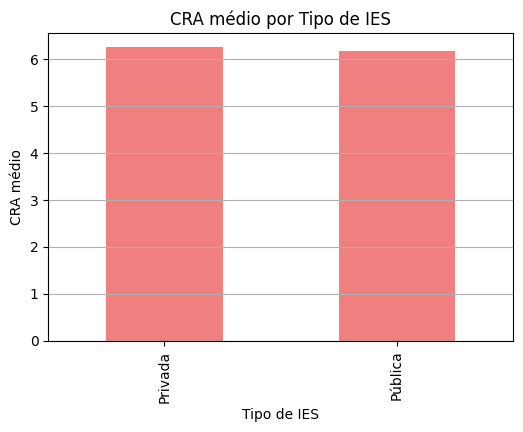

In [107]:
# CRA médio por Tipo_IES
cra_por_ies = df.groupby("Tipo_IES")["CRA"].mean()
print(cra_por_ies)

cra_por_ies.plot(kind="bar", color="lightcoral", figsize=(6,4))
plt.title("CRA médio por Tipo de IES")
plt.ylabel("CRA médio")
plt.xlabel("Tipo de IES")
plt.grid(axis="y")
plt.show()


Acesso_Internet
Boa         6.294981
Instável    6.160760
Ruim        6.155882
Name: CRA, dtype: float64


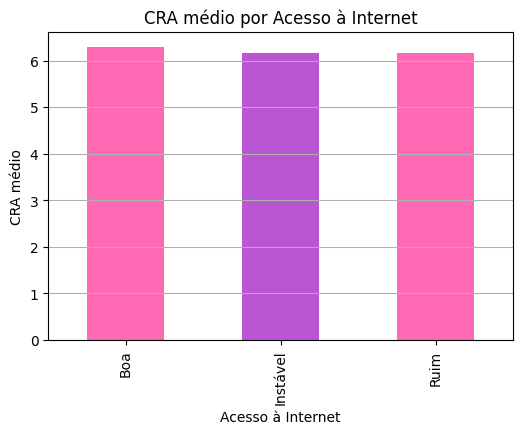

In [111]:
# CRA médio por Acesso_Internet
cra_por_internet = df.groupby("Acesso_Internet")["CRA"].mean()
print(cra_por_internet)

cra_por_internet.plot(kind="bar", color=["hotpink", "mediumorchid"], figsize=(6,4))
plt.title("CRA médio por Acesso à Internet")
plt.ylabel("CRA médio")
plt.xlabel("Acesso à Internet")
plt.grid(axis="y")
plt.show()


## 8. Conclusões

Com base nos resultados do modelo e nas análises, a hipótese de que estudantes com bolsa ou financiamento mantêm CRA semelhante ou superior aos não bolsistas é parcialmente verdadeira: o modelo apresentou desempenho consistente e os erros médios indicam previsões confiáveis. As análises mostraram que, em média,  bolsistas têm CRA comparável ou ligeiramente superior, independentemente do tipo de IES. Outros fatores como acesso à internet não alteraram significativamente esse padrão de resultados. Tais achados sugerem que a bolsa ou financiamento contribui para manter o desempenho acadêmico. Estudos adicionais com mais variáveis talvez possam oferecer conclusões ainda mais robustas.